In [1]:
#tensorflow 2.2.2
#others newest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import tensorflow as tf
from glob import glob
import pickle
import numpy as np
import random
import os
import tqdm.keras as tk
# from keras_tqdm import TQDMNotebookCallback
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
train_path = "./new_train/new_train"
test_path = "./new_val_in/new_val_in"

In [3]:
data_list = glob(os.path.join(train_path, '*'))
random.shuffle(data_list)
print(int(len(data_list)*1))
data_list = data_list[:len(data_list)]
print(int(len(data_list)*1))

train_list = data_list[:int(len(data_list)*0.9)-47]
valid_list = data_list[int(len(data_list)*0.9)+95:]
print(len(train_list))
print(len(valid_list))

205942
205942
185300
20500


In [13]:
batch_size = 100
epochs = 10
latent_dim = 256
num_encoder_tokens = 1
num_decoder_tokens = 1

In [6]:

def train_generator_y(train_list, batch_size):
    index = 0
    while True:
        encoder_input_data = np.zeros((batch_size, 19, 1), dtype='float32')
        decoder_input_data = np.zeros((batch_size, 30, 1), dtype='float32')
        decoder_target_data = np.zeros((batch_size, 30, 1), dtype='float32')
        for i in range(batch_size):
            train_path = train_list[index]
            with open(train_path, 'rb') as f:
                data = pickle.load(f)                
                agent_id = data['agent_id']
                idx = np.where(data["track_id"] == data["agent_id"])[0][0]
                input_data = data['p_in'][idx,:,:]                
                input_data_x = input_data[:,1]
                input_data_x = input_data_x[..., np.newaxis]
                encoder_input_data[i,:,:] = input_data_x
                                
                last_input = input_data_x[-1:]
                decoder_input_data[i,0,:] = last_input
                output_data = data['p_out'][idx,:,:]
                output_data_x = output_data[:,1]
                output_data_x = output_data_x[..., np.newaxis]
                decoder_input_data[i,1:,:] = output_data_x[:-1]
                
                decoder_target_data[i,:,:] = output_data_x

               
            index += 1
        if index == len(train_list):
            index = 0

        yield [encoder_input_data, decoder_input_data], decoder_target_data

        
def valid_generator_y(valid_list, batch_size):
    index = 0
    while True:
        encoder_input_data = np.zeros((batch_size, 19, 1), dtype='float32')
        decoder_input_data = np.zeros((batch_size, 30, 1), dtype='float32')
        decoder_target_data = np.zeros((batch_size, 30, 1), dtype='float32')
        for i in range(batch_size):
            valid_path = valid_list[index]
            with open(valid_path, 'rb') as f:
                data = pickle.load(f)                
                agent_id = data['agent_id']
                idx = np.where(data["track_id"] == data["agent_id"])[0][0]
                
                input_data = data['p_in'][idx,:,:]
                
                input_data_x = input_data[:,1]
                input_data_x = input_data_x[..., np.newaxis]
                encoder_input_data[i,:,:] = input_data_x
                
                last_input = input_data_x[-1:]
                decoder_input_data[i,0,:] = last_input
                output_data = data['p_out'][idx,:,:]
                output_data_x = output_data[:,1]
                output_data_x = output_data_x[..., np.newaxis]
                decoder_input_data[i,1:,:] = output_data_x[:-1]
                
                decoder_target_data[i,:,:] = output_data_x
                
            index += 1
        if index == len(valid_list):
            index = 0

        yield [encoder_input_data, decoder_input_data], decoder_target_data

In [7]:
#encoder portion
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True, activation="relu")
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

#decoder portion
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, activation="relu")
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
train_gen_y = train_generator_y(train_list,100)
valid_gen_y = valid_generator_y(valid_list,100)

In [9]:
# next(train_gen_y)

In [10]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


model.compile(optimizer='adam', loss=root_mean_squared_error)
checkpointer = ModelCheckpoint(filepath='./lstm_seqtoseq_y_weights.hdf5', verbose=2, save_best_only=True, mode='min')

In [11]:
hist_y = model.fit(train_gen_y,
                        verbose=2,
                        epochs=10,
                        validation_data=valid_gen_y,
                        steps_per_epoch=(len(train_list)/100),
                        validation_steps=(len(valid_list)/100),
                        callbacks=[checkpointer])

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10

Epoch 00001: val_loss improved from inf to 193.36434, saving model to ./lstm_seqtoseq_y_weights.hdf5
1853/1853 - 353s - loss: 1585.5848 - val_loss: 193.3643
Epoch 2/10
Epoch 1/10

Epoch 00002: val_loss improved from 193.36434 to 85.93152, saving model to ./lstm_seqtoseq_y_weights.hdf5
1853/1853 - 340s - loss: 505.4893 - val_loss: 85.9315
Epoch 3/10
Epoch 1/10

Epoch 00003: val_loss did not improve from 85.93152
1853/1853 - 327s - loss: 437.8099 - val_loss: 277.1742
Epoch 4/10
Epoch 1/10

Epoch 00004: val_loss did not improve from 85.93152
1853/1853 - 329s - loss: 429.9861 - val_loss: 482.7445
Epoch 5/10
Epoch 1/10

Epoch 00005: val_loss did not improve from 85.93152
1853/1853 - 345s - loss: 471.7304 - val_loss: 345.0445
Epoch 6/10
Epoch 1/10

Epoch 00006: val_loss did not improve from 85.93152
1853/1853 - 329s - loss: 726.7735 - val_loss: 514.5745
Epoch 7/10
Epoch 1/10



drawing the training process...


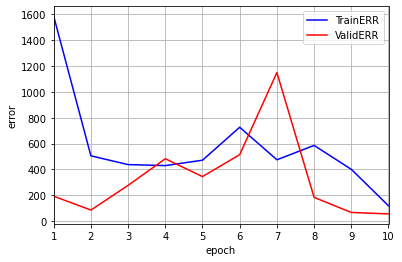

In [15]:
TrainERR=hist_y.history['loss']
ValidERR=hist_y.history['val_loss']
# print('@%f, Minimun error:%f, at iteration: %i' % (hist.history['val_loss'][epoch-1], np.min(np.asarray(ValidERR)),np.argmin(np.asarray(ValidERR))+1))
print('drawing the training process...')
plt.figure(2)
plt.plot(range(1,epochs+1),TrainERR,'b',label='TrainERR')
plt.plot(range(1,epochs+1),ValidERR,'r',label='ValidERR')
plt.xlim([1,epochs])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('error')
plt.grid(True)
fig1 = plt.gcf()
fig1.savefig('lstm20epochs_y.png', dpi=100)
plt.show()

In [16]:
#encoder model inference
encoder_model = Model(encoder_inputs, encoder_states)

#decoder model inference
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)


decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [18]:
def decode_sequence(input_seq):
    #input seq is a scene 
    # Encode the input as state vectors.
#     print("input seq shape is ",input_seq.shape)
    input_shaped = np.empty((1,19,1))
    input_shaped[0,:,:] = input_seq
#     encoder_model.summary()
#     input_shaped = np.reshape(input_seq, (input_seq.shape[0], 1, input_seq.shape[1]))
#     print("inpiut shaped is ", input_shaped)
    states_value = encoder_model.predict(input_shaped)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0,0,:] = input_seq[len(input_seq)-1] 

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    index = 0
    decoded_sentence = ''
    decoded_array = np.empty((30,1))
    while index < 30:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
        
        # Sample a token
        decoded_array[index,:] = output_tokens[0][0]
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, :] = output_tokens
        # Update states
        states_value = [h, c]
        
        index += 1
    
    return decoded_array

In [19]:
columns = []
columns.append("ID")
for i in range(30):
    num = "v"+str(i+1)
    columns.append(num)
    
df = pd.DataFrame(columns=columns)

In [20]:
test_list = glob(os.path.join(test_path, '*'))
print(len(test_list))

for x in tqdm(test_list):
    test_x = np.empty((30,2))
    with open(x, 'rb') as f:
        data = pickle.load(f)
        new_row = []
        scene_id = data['scene_idx']
        new_row.append(scene_id)
        agent_id = data['agent_id']
        idx = np.where(data["track_id"] == data["agent_id"])[0][0]   
        input_data = data['p_in'][idx,:,1]
        input_data = input_data[..., np.newaxis]
        test_x = decode_sequence(input_data)
        flat = test_x.flatten()
        for elem in flat:
            new_row.append(elem)
        df_length = len(df)
        df.loc[df_length] = new_row

  0%|          | 0/3200 [00:00<?, ?it/s]

3200


100%|██████████| 3200/3200 [07:42<00:00,  6.92it/s]


In [21]:
df['ID'] = df['ID'].map(round)

In [22]:
df

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30
0,34189,943.458252,946.310120,937.460999,939.080322,939.334106,938.248047,926.499390,954.075623,927.077942,...,938.656738,950.309021,933.116638,921.022156,924.639587,919.902161,933.603821,908.962524,900.989441,907.980652
1,1454,1243.251953,1244.792358,1238.474976,1239.475952,1239.644409,1238.189697,1222.745239,1258.884888,1223.183228,...,1238.625732,1254.053101,1230.334473,1215.466675,1220.177734,1213.914307,1231.764771,1199.399414,1188.716187,1198.040649
2,32404,1531.553589,1532.030151,1528.396851,1529.320557,1529.095215,1527.609375,1508.862549,1552.190552,1507.803345,...,1525.734619,1544.324463,1512.733765,1496.604492,1502.613892,1495.214355,1516.975586,1477.232788,1463.805176,1475.059692
3,33991,1140.044800,1143.077026,1134.729370,1136.813843,1136.759399,1135.566650,1121.514160,1154.018311,1121.182861,...,1134.649536,1148.565552,1126.363281,1113.075684,1117.519287,1111.916138,1128.322144,1098.620972,1088.816772,1097.190186
4,30427,992.033386,993.977966,985.884399,987.094543,987.360107,986.134338,973.707947,1002.864075,974.522461,...,986.841858,999.212463,981.197571,968.496704,972.148743,967.135376,981.480896,955.601135,947.178223,954.659729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,7717,491.598999,492.847870,483.895599,463.095642,486.570007,485.475342,479.270416,495.047333,482.595856,...,493.202545,501.374420,495.997894,487.113617,490.294800,487.626068,494.693268,483.157379,479.105621,482.445801
3196,5734,645.472900,648.406921,637.839966,637.437012,639.507324,638.759460,630.577271,651.765137,633.469482,...,643.323242,651.577820,642.529480,631.848877,634.456055,630.787476,640.553528,623.512878,618.535583,623.313904
3197,33829,917.737732,921.346924,911.331482,913.419067,913.585876,912.595642,901.238159,927.971619,901.687622,...,912.839478,924.087097,907.287292,895.557739,899.163818,894.589294,907.950623,883.967957,876.238586,882.947083
3198,4515,1424.759399,1425.451782,1421.004517,1421.661133,1421.682251,1420.125610,1402.532593,1443.459717,1402.359497,...,1419.705688,1437.227173,1408.899902,1392.907593,1398.403809,1391.347656,1411.677856,1374.648315,1362.277100,1372.892212


In [23]:
columns_test = []
columns_test.append("ID")
for i in range(38):
    num = "v"+str(i+1)
    columns_test.append(num)
    
df_test = pd.DataFrame(columns=columns_test)


for x in test_list:
    with open(x, 'rb') as f:
        data = pickle.load(f)
        new_row = []
        scene_id = data['scene_idx']
        new_row.append(scene_id)
        agent_id = data['agent_id']
        idx = np.where(data["track_id"] == data["agent_id"])[0][0]   
        input_data = data['p_in'][idx,:,:]
        for i in range(38):
            new_row.append(input_data.flatten()[i])
        df_length = len(df_test)
        df_test.loc[df_length] = new_row


In [24]:
df_test

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38
0,34189.0,595.562073,936.528992,595.544006,935.963928,595.649536,936.135559,595.667480,935.907166,595.707275,...,596.247437,933.134216,596.408813,932.617249,596.376892,932.458801,596.398865,932.383728,596.435852,932.086731
1,1454.0,579.748535,1236.775146,579.938965,1236.378784,580.365906,1235.755371,580.250061,1235.585815,580.636536,...,582.202637,1229.476196,582.441162,1228.873901,582.233643,1228.338623,582.358765,1227.714478,582.552185,1227.146851
2,32404.0,596.773865,1526.008545,596.632812,1526.094360,596.576294,1526.078125,596.498291,1526.105225,596.269348,...,593.871521,1525.996704,593.444214,1525.877930,592.983887,1525.745117,592.521118,1525.561646,592.052429,1525.351685
3,33991.0,416.036377,1131.377930,415.903534,1131.828003,415.764526,1132.141724,415.624969,1132.613525,415.485992,...,413.496155,1136.546021,413.229736,1136.827271,412.953491,1137.106201,412.656830,1137.415649,412.440948,1137.703003
4,30427.0,591.568970,986.132019,591.628113,985.414978,591.787476,984.686584,591.843811,984.013428,591.922363,...,592.989380,975.482605,592.937866,974.617676,593.038269,973.842896,593.211975,973.422119,593.310730,972.728210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,7717.0,1875.832397,471.821625,1876.988770,472.846069,1878.359009,473.901123,1879.551514,474.995544,1880.836060,...,1893.428467,486.367584,1894.691895,487.410950,1895.904175,488.400177,1897.126709,489.408905,1898.337891,490.422180
3196,5734.0,2069.424072,635.513184,2068.171631,634.562622,2066.786621,633.569031,2065.407471,632.559387,2064.130371,...,2050.308594,621.376709,2048.978516,620.367310,2047.582764,619.339417,2046.292236,618.321838,2044.849243,617.266418
3197,33829.0,726.628113,909.115906,726.607422,909.657166,726.652161,909.966309,726.634827,909.686401,726.640259,...,727.459900,912.470154,727.510315,912.951233,727.566162,913.033325,727.508850,913.745483,727.478943,914.257568
3198,4515.0,582.553650,1419.214355,582.546326,1418.776367,582.498047,1418.246216,582.581909,1417.869873,582.607849,...,582.132080,1412.069458,582.254089,1410.913574,582.018677,1410.472656,582.125854,1409.070923,582.208496,1408.635132


In [25]:
df.to_csv(r'./lstm_y.csv', index = False, header=True)